# STAT 301 Project: AIRBNB

 https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities/data?select=london_weekdays.csv

In [29]:
library(dplyr)
library(tidyr)
library(readr)
library(broom)
library(stringr)
library(ggplot2)
library(car)
library(skimr)


## 1. Data Set Overview

### Merging Multiple CSV Files and Creating a Day Type Variable

In this step, we merged multiple Airbnb datasets and created a new categorical variable indicating whether each observation comes from a weekday or a weekend.

#### Step-by-step explanation:

1. **File List Definition**  
   We defined a character vector `file_list` that contains the names of six CSV files, representing data from three cities (Barcelona, London, Paris) across both weekdays and weekends.

2. **Reading and Tagging Data**  
   We used `lapply()` to loop through each file name:
   - Each file was read using `read_csv()`.
   - We created a new column `day_type` using `mutate()`, which assigns either `"weekday"` or `"weekend"` depending on whether the file name contains the string `"weekends"`. This was done using `str_detect()` from the `stringr` package.

3. **Merging Datasets**  
   All the data frames were combined into a single data frame `df_all` using `bind_rows()`.

4. **Result Inspection**  
   We used `head(df_all)` to view the first few rows and `summary(df_all)` to examine the summary statistics of the merged dataset.

#### Purpose:
By creating the `day_type` variable directly from the file names, we are able to track which observations came from weekdays and which from weekends. This allows for further grouped analysis and modeling based on day-of-week effects.


In [30]:
file_list <- c("barcelona_weekdays.csv", "barcelona_weekends.csv",
               "london_weekdays.csv", "london_weekends.csv",
               "paris_weekdays.csv", "paris_weekends.csv")

df_all <- file_list %>%
  lapply(function(file) {
    read_csv(file) %>%
      mutate(
        day_type = ifelse(str_detect(file, "weekends"), "weekend", "weekday")
      )
  }) %>%
  bind_rows()



New names:
• `` -> `...1`
Rows: 1555 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 1278 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 4614 Columns: 20
── Column specification ─────────────────

| Column Name                | Description                                                                          |
|---------------------------|--------------------------------------------------------------------------------------|
| **realSum**               | *The total price of the Airbnb listing.* (Numeric)                                   |
| **room_type**             | *The type of room being offered (e.g. private, shared, etc.).* (Categorical)         |
| **room_shared**           | *Whether the room is shared or not.* (Boolean)                                       |
| **room_private**          | *Whether the room is private or not.* (Boolean)                                      |
| **person_capacity**       | *The maximum number of people that can stay in the room.* (Numeric)                  |
| **host_is_superhost**     | *Whether the host is a superhost or not.* (Boolean)                                  |
| **multi**                 | *Whether the listing is for multiple rooms or not.* (Boolean)                        |
| **biz**                   | *Whether the listing is for business purposes or not.* (Boolean)                     |
| **cleanliness_rating**    | *The cleanliness rating of the listing.* (Numeric)                                   |
| **guest_satisfaction_overall** | *The overall guest satisfaction rating of the listing.* (Numeric)           |
| **bedrooms**              | *The number of bedrooms in the listing.* (Numeric)                                   |
| **dist**                  | *The distance from the city centre.* (Numeric)                                       |
| **metro_dist**            | *The distance from the nearest metro station.* (Numeric)                             |
| **attr_index**            | *An index representing the number and popularity of nearby attractions.* (Numeric)   |
| **attr_index_norm**       | *Normalized version of `attr_index` between 0 and 1.* (Numeric)                      |
| **rest_index**            | *An index representing the number and quality of nearby restaurants.* (Numeric)      |
| **rest_index_norm**       | *Normalized version of `rest_index` between 0 and 1.* (Numeric)                      |
| **lng**                   | *The longitude of the listing.* (Numeric)                                            |
| **lat**                   | *The latitude of the listing.* (Numeric)                                             |
| **day_type**              | *Indicates whether the listing is for a weekday or weekend.* (Categorical)           |


In [31]:
head(df_all)
n_obs <- nrow(df_all)
n_vars <- ncol(df_all)

cat("Number of observations:", n_obs, "\n")
cat("Number of variables:", n_vars, "\n")


...1,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,⋯,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,day_type
<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,474.3175,Entire home/apt,FALSE,FALSE,4,FALSE,0,1,10,⋯,1,1.111996,0.63049095,526.4694,17.94293,915.5871,20.15489,2.17556,41.39624,weekday
1,169.8978,Private room,FALSE,TRUE,2,TRUE,1,0,10,⋯,1,1.751839,0.12401717,320.1275,10.91046,794.2774,17.48449,2.14906,41.38714,weekday
2,161.9848,Private room,FALSE,TRUE,4,FALSE,0,1,9,⋯,1,1.670493,0.08032198,344.0739,11.72659,840.6736,18.50581,2.15357,41.37859,weekday
3,367.9568,Entire home/apt,FALSE,FALSE,3,FALSE,0,1,10,⋯,1,1.475847,0.09310686,400.0574,13.63460,946.5899,20.83736,2.16839,41.37390,weekday
4,196.8953,Private room,FALSE,TRUE,3,FALSE,1,0,9,⋯,1,1.855452,0.27248605,346.0422,11.79368,792.2960,17.44087,2.15238,41.37699,weekday
5,330.9517,Entire home/apt,FALSE,FALSE,3,FALSE,0,1,9,⋯,2,2.565611,0.70129045,391.0874,13.32889,525.5139,11.56818,2.18197,41.40842,weekday


Number of observations: 19514 
Number of variables: 21 


In [34]:
as.data.frame(skim(df_all))

skim_type,skim_variable,n_missing,complete_rate,character.min,character.max,character.empty,character.n_unique,character.whitespace,logical.mean,logical.count,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
character,room_type,0,1,11,15,0,3,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
character,day_type,0,1,7,7,0,2,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
logical,room_shared,0,1,NA,NA,NA,NA,NA,0.007994261,"FAL: 19358, TRU: 156",NA,NA,NA,NA,NA,NA,NA,NA
logical,room_private,0,1,NA,NA,NA,NA,NA,0.479911858,"FAL: 10149, TRU: 9365",NA,NA,NA,NA,NA,NA,NA,NA
logical,host_is_superhost,0,1,NA,NA,NA,NA,NA,0.155170647,"FAL: 16486, TRU: 3028",NA,NA,NA,NA,NA,NA,NA,NA
numeric,...1,0,1,NA,NA,NA,NA,NA,NA,NA,1965.5297735,1365.3942401,0.000000000,813.0000000,1730.5000000,2950.0000000,5378.000000,▇▆▅▃▂
numeric,realSum,0,1,NA,NA,NA,NA,NA,NA,NA,362.7964305,413.0844678,54.328653073,186.2447165,278.2179141,434.6143828,16445.614689,▇▁▁▁▁
numeric,person_capacity,0,1,NA,NA,NA,NA,NA,NA,NA,2.8496977,1.2270997,2.000000000,2.0000000,2.0000000,4.0000000,6.000000,▇▁▂▁▁
numeric,multi,0,1,NA,NA,NA,NA,NA,NA,NA,0.2719586,0.4449801,0.000000000,0.0000000,0.0000000,1.0000000,1.000000,▇▁▁▁▃


## Plots

### Comparison of Airbnb Price Distributions (Original vs Log Scale)

The two histograms below compare the distribution of Airbnb listing prices (`realSum`) **before and after log transformation**:

- **Lower plot**: Raw price distribution is **highly right-skewed**, with most listings priced under €200 and a long tail of expensive properties.
- **Upper plot**: Log-transformed prices are **approximately symmetric and bell-shaped**, making them more suitable for linear regression modeling.

> This comparison highlights the **importance of log transformation** when modeling skewed variables like price, as it reduces the impact of extreme values and better satisfies linear model assumptions.


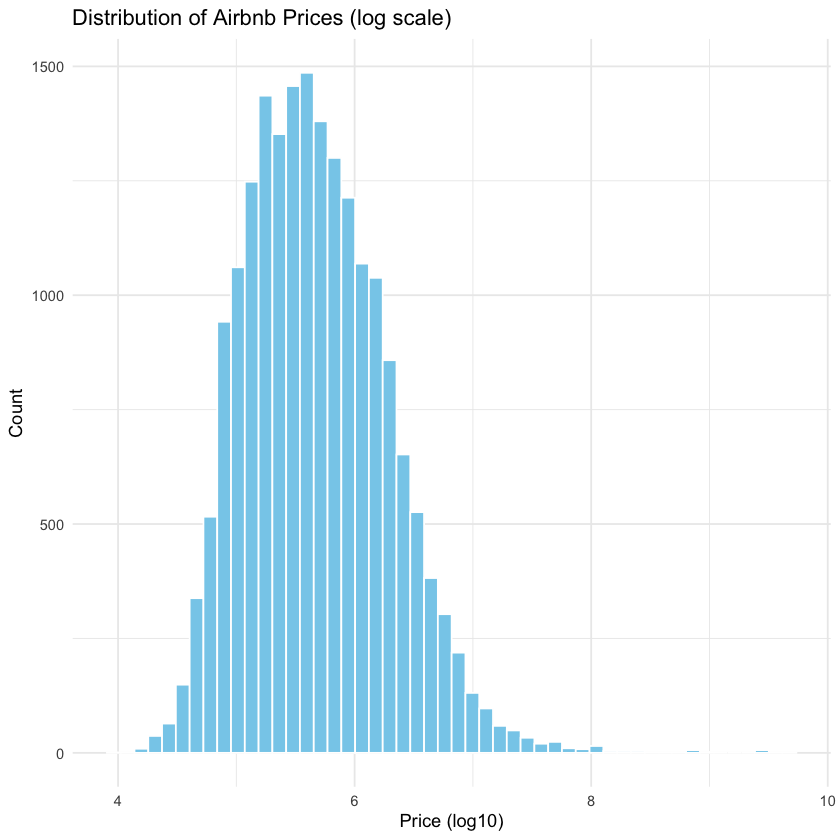

In [ ]:
ggplot(df_all, aes(x = log(realSum))) +
  geom_histogram(bins = 50, fill = "skyblue", color = "white") +
  labs(title = "Distribution of Airbnb Prices (log scale)",
       x = "Price (log10)",
       y = "Count") +
  theme_minimal()



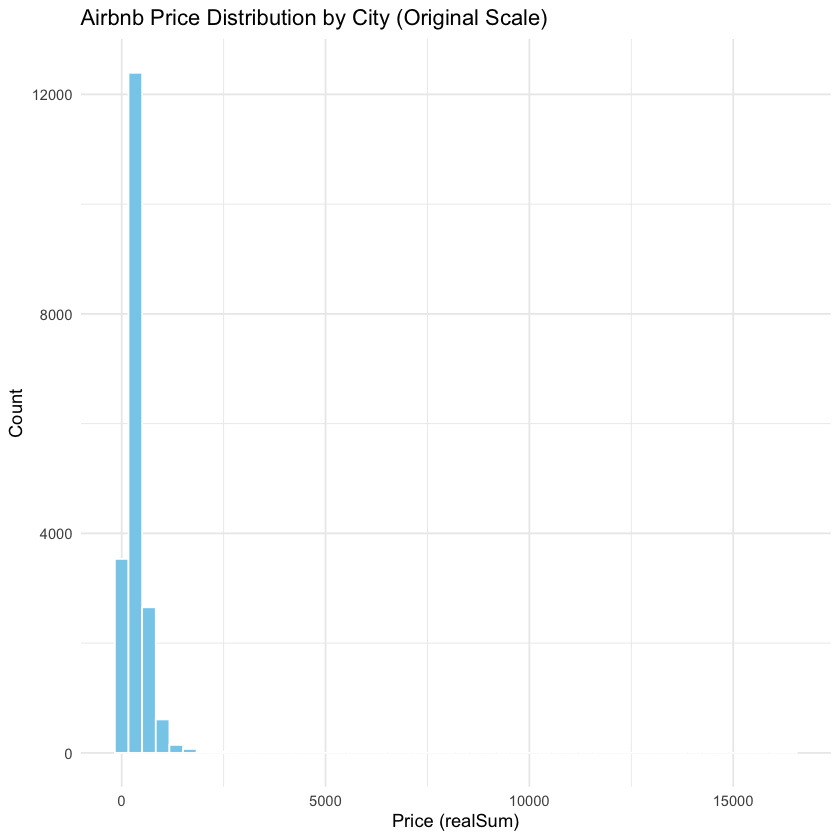

In [ ]:
ggplot(df_all, aes(x = realSum)) +
  geom_histogram(bins = 50, fill = "skyblue", color = "white") +
  labs(
    title = "Airbnb Price Distribution by City (Original Scale)",
    x = "Price (realSum)",
    y = "Count"
  ) +
  theme_minimal()

### Price by Room Type
Room type may correlated to the price significantly \
This plot shows the distribution of listing prices across different room types. We use a log scale on the y-axis due to the right-skewed distribution of prices.


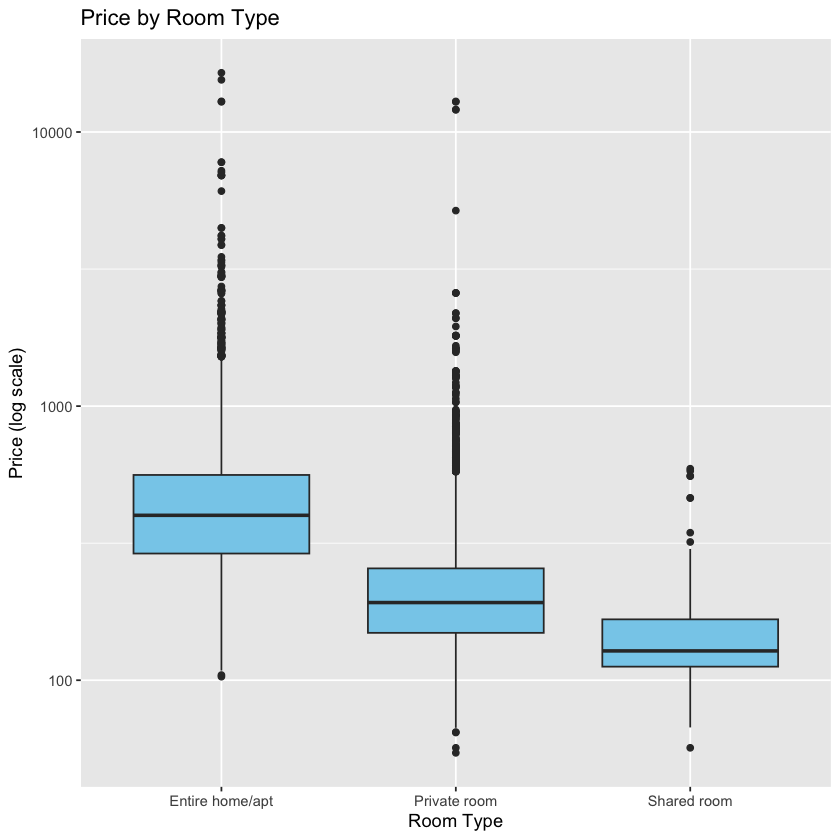

In [ ]:
ggplot(df_all, aes(x = room_type, y = realSum)) +
  geom_boxplot(fill = "skyblue") +
  scale_y_log10() +
  labs(title = "Price by Room Type", x = "Room Type", y = "Price (log scale)")


### Price by Distance from City Centre,for different day type

It is intuitive that listings closer to the city centre tend to be more expensive due to higher demand and convenience.  
However, the visualizations indicate that the relationship between distance and price may be **nonlinear**.


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


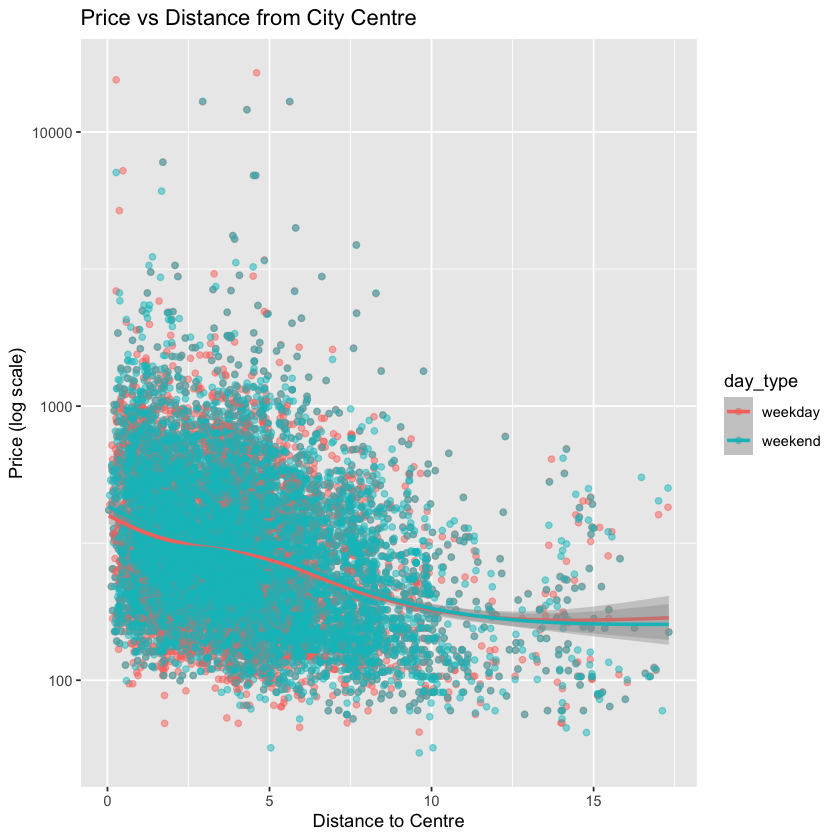

In [ ]:
ggplot(df_all, aes(x = dist, y = realSum, color = day_type)) +
  geom_point(alpha = 0.5) +
  geom_smooth() +  
  scale_y_log10() +
  labs(title = "Price vs Distance from City Centre",
       x = "Distance to Centre", y = "Price (log scale)")



## Price Distribution by Day Type

We hypothesize that **Airbnb listing prices may vary between weekdays and weekends** due to differences in demand:

- **On weekends**, people are more likely to travel for leisure or short vacations, which can drive up demand and lead to higher prices.
- **On weekdays**, bookings are more likely to come from business travelers, with potentially lower or more consistent pricing, especially in cities with high business activity.
- However, the mean is so close that may be not significant.

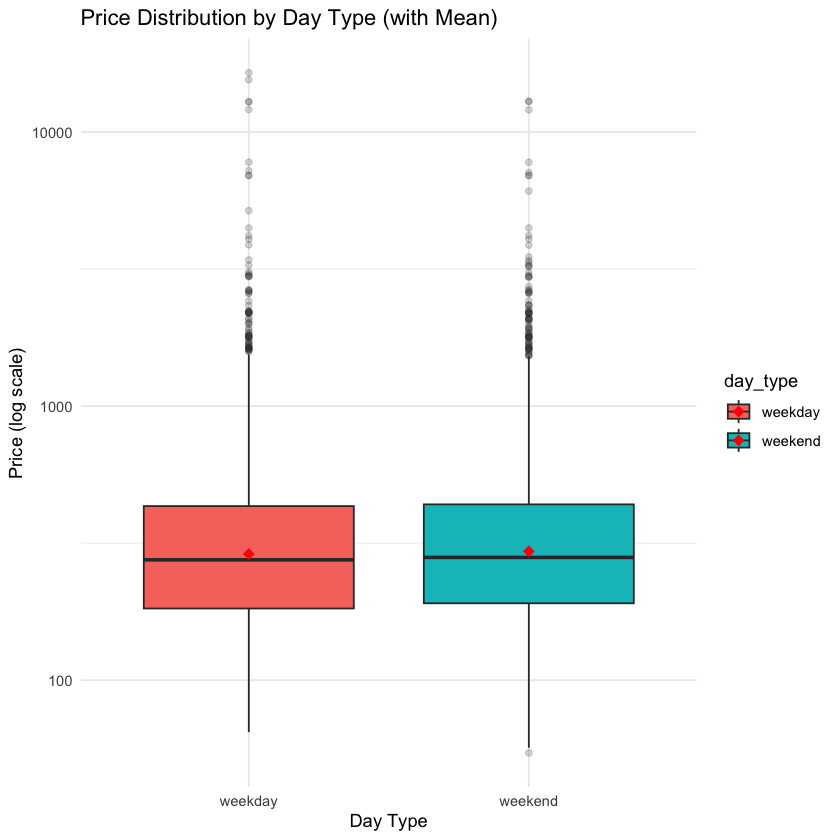

In [ ]:
ggplot(df_all, aes(x = day_type, y = realSum, fill = day_type)) +
  geom_boxplot(outlier.alpha = 0.2) +
  stat_summary(fun = mean, geom = "point", shape = 18, size = 3, color = "red") +
  scale_y_log10() +
  labs(title = "Price Distribution by Day Type (with Mean)",
       x = "Day Type", y = "Price (log scale)") +
  theme_minimal()


### Price Distribution by Person Capacity (Boxplot, log scale)

The boxplot below displays the distribution of Airbnb prices (log-transformed) across different levels of `person_capacity` (the maximum number of people a listing can accommodate). Each box represents the interquartile range (IQR) for listings that can host a specific number of guests.

> This plot helps us understand how the number of guests a listing can accommodate relates to price, and motivates including `person_capacity` in our predictive model, potentially with interaction or nonlinear terms.

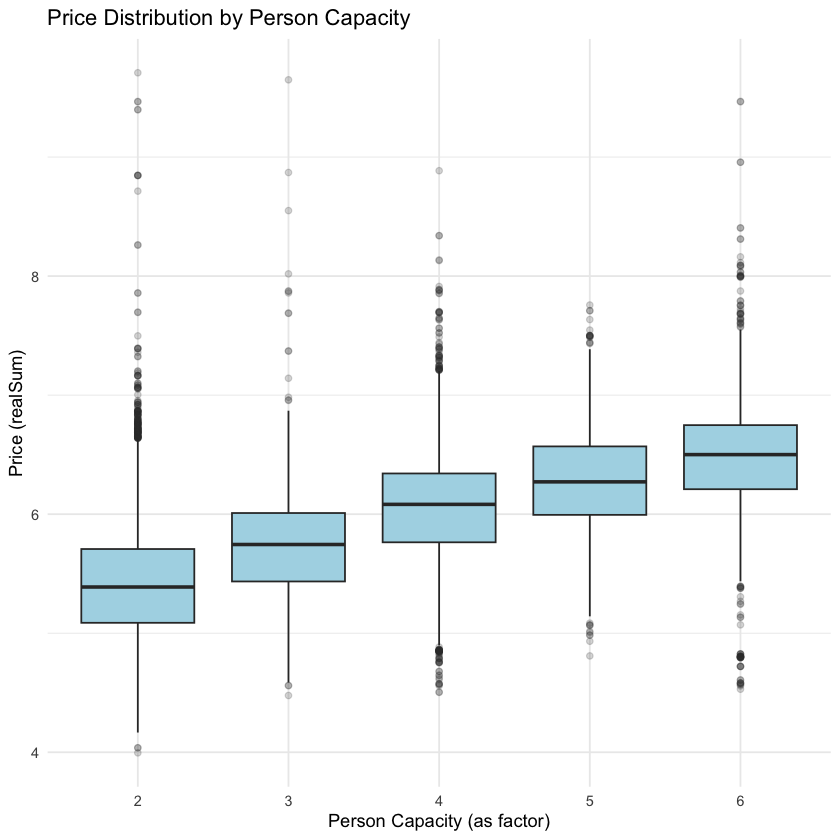

In [ ]:
ggplot(df_all, aes(x = factor(person_capacity), y = log(realSum))) +
  geom_boxplot(fill = "lightblue", outlier.alpha = 0.2) +
  labs(
    title = "Price Distribution by Person Capacity",
    x = "Person Capacity (as factor)",
    y = "Price (realSum)"
  ) +
  theme_minimal()



## Price vs Cleanliness Rating 

Observations on Price vs Cleanliness Rating

Although the boxplot shows that **median prices are relatively stable** across different cleanliness ratings, an interesting pattern emerges at the upper end of the price range:

- **High-price outliers** are more frequent among listings with high cleanliness scores (especially 9 and 10).
- This suggests that cleanliness may not significantly influence the **average price**, but could be an important attribute for **high-end or luxury listings**.
- In contrast, listings with low cleanliness scores rarely command high prices, indicating a potential ceiling effect at low ratings.

> These findings imply that while `cleanliness_rating` may have limited explanatory power for typical listings, it could be useful in identifying or modeling the upper tail of the price distribution.


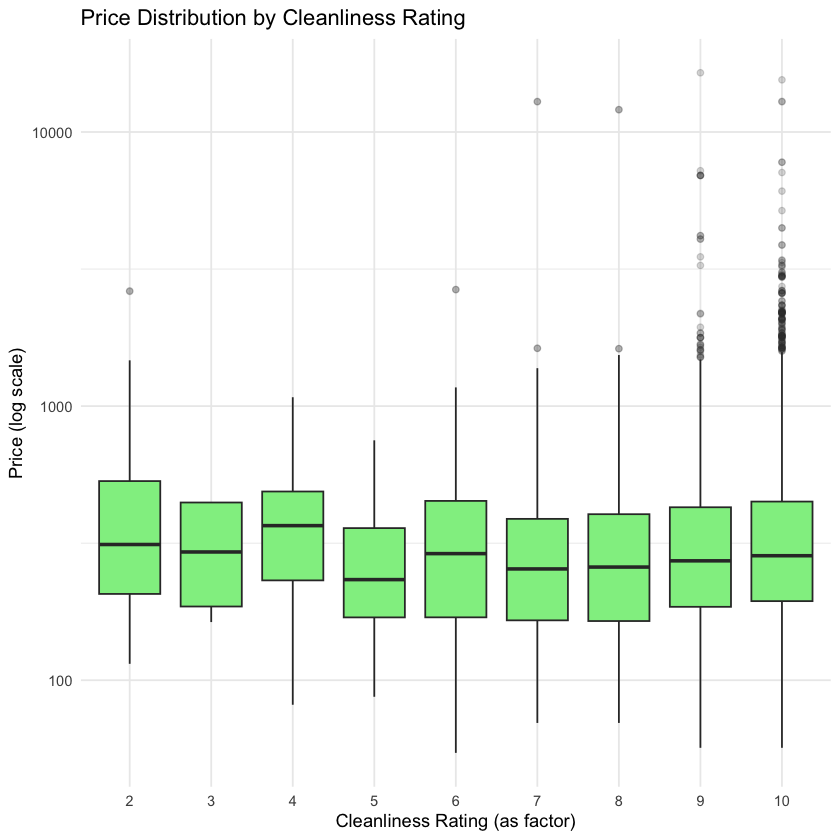

In [ ]:
ggplot(df_all, aes(x = factor(cleanliness_rating), y = realSum)) +
  geom_boxplot(fill = "lightgreen", outlier.alpha = 0.2) +
  scale_y_log10() +
  labs(
    title = "Price Distribution by Cleanliness Rating",
    x = "Cleanliness Rating (as factor)",
    y = "Price (log scale)"
  ) +
  theme_minimal()




### Research Question

**Question:**  
How do room characteristics, location features, and customer ratings affect Airbnb listing prices in major European cities?

**Response Variable:**  
- `log(realSum)` — the natural logarithm of the total price of the Airbnb listing.  
  (We use log-transformed price to address skewness and stabilize variance.)

**Explanatory Variables:**  
- `room_type` (categorical: entire, private, shared)
- `bedrooms`, `person_capacity` (room size and capacity)
- `cleanliness_rating` and its square (nonlinear rating effect)
- `guest_satisfaction_overall` and its square (nonlinear guest perception)
- `day_type` (weekday vs weekend)
- `dist` and `metro_dist`, and their squares (nonlinear location effects)
- `attr_index_norm`, `rest_index_norm` (normalized neighborhood amenities)
- Interaction terms: `room_type * bedrooms`, `room_type * person_capacity`, `day_type * person_capacity`

**Purpose:**  
Our goal is both **inference** and **prediction**:
- **Inference:** Identify which variables significantly affect listing prices and interpret their relationships.
- **Prediction:** Develop a regression model that can predict Airbnb listing prices from room and location features.

The dataset contains hundreds of observations from multiple cities, with detailed listing and location attributes. This richness allows us to examine price behavior across different market segments and understand the drivers of pricing.


### Model Assumptions AND Planning

To apply linear regression, we assume:

1. **Linearity in parameters**:  
   The model assumes that the outcome (here, log-transformed price) is a linear function of the **parameters**.  
   Note that this does **not** require that the relationship between predictors and the response be strictly linear.  
   For example, by including **polynomial terms** (e.g., `cleanliness_rating^2`, `dist^2`) and **interactions** (e.g., `room_type * bedrooms`), we allow the model to capture **nonlinear** or **conditional effects** while maintaining a linear structure in coefficients.

2. **Independence**:  
   The observations are assumed to be independent. This may be violated if there are clusters (e.g., listings from the same host or neighborhood).

3. **Homoscedasticity**:  
   The variance of residuals is assumed constant across all levels of the predictors.  
   We partially address this with a log transformation of the response variable.

4. **Normality of residuals**:  
   For inference purposes, we assume that residuals are approximately normally distributed.  
   This assumption becomes less critical when the focus is prediction, or when using large sample sizes.

5. **No perfect multicollinearity**:  
   Predictors must not be exact linear combinations of each other.  
   This can be checked using variance inflation factors (VIF).

### Proposed Method: Multiple Linear Regression with Transformations and Interactions

We propose using a **multiple linear regression model** on the log-transformed price, with polynomial and interaction terms.

#### Why this method is appropriate:
- It allows for **interpretability**: coefficients can be interpreted as percentage effects on price.
- The **log transformation** helps address **skewed price distribution** and **heteroscedasticity**.
- By including **quadratic terms**, we capture **nonlinear relationships** (e.g., diminishing effects).
- Interaction terms allow modeling **heterogeneous effects** (e.g., the effect of bedrooms may differ by room type).
- Regression provides tools for **inference** (significance testing, confidence intervals) and **prediction** (fitted values, cross-validation).



## Model Build First Try (No Interaction Model，NO Log)

### Model Specification and Hypotheses

We propose the following additive linear regression model to examine how room characteristics, guest satisfaction, and location features affect Airbnb listing prices.

#### Model Expression

Let  
- \( Y_i \) be the total price (`realSum`) of listing \( i \)

The model is expressed as:

$$
Y_i = \beta_0 + \beta_1 \cdot \text{room\_type}_i + \beta_2 \cdot \text{person\_capacity}_i + \beta_3 \cdot \text{cleanliness\_rating}_i + \beta_4 \cdot \text{guest\_satisfaction\_overall}_i + \beta_5 \cdot \text{day\_type}_i + \beta_6 \cdot \text{dist}_i + \beta_7 \cdot \text{metro\_dist}_i + \varepsilon_i
$$

Where:

- \( \beta_0 \) is the intercept  
- \( \beta_1, \dots, \beta_7 \) are the coefficients to be estimated  
- \( \varepsilon_i \sim \mathcal{N}(0, \sigma^2) \) is the error term

Note:

- `room_type` and `day_type` are categorical variables and will be dummy-coded.  
- All other predictors are treated as continuous.

---

### Hypothesis Testing

For each coefficient \( \beta_j \), we test the following hypotheses:

$$
\begin{aligned}
H_0 &: \beta_j = 0 \quad \text{(no effect on price)} \\
H_A &: \beta_j \ne 0 \quad \text{(significant effect on price)}
\end{aligned}
$$

This hypothesis test helps determine whether each predictor has a statistically significant relationship with the listing price, after controlling for other variables in the model.



In [ ]:
model_addtive_full <- lm(realSum ~room_type + person_capacity + cleanliness_rating + guest_satisfaction_overall + day_type + dist + metro_dist, df_all)

In [ ]:
model_addtive_full_result <- tidy(model_addtive_full)|>mutate(across(where(is.numeric), ~ round(.x, 4)))
model_addtive_full_result

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.1594,27.6729,0.2226,0.8239
room_typePrivate room,-130.6908,6.2458,-20.9245,0.0000
room_typeShared room,-299.3709,30.3192,-9.8740,0.0000
person_capacity,97.7283,2.4989,39.1093,0.0000
cleanliness_rating,15.6566,3.6042,4.3440,0.0000
guest_satisfaction_overall,0.6803,0.3802,1.7894,0.0736
day_typeweekend,2.5523,5.3874,0.4738,0.6357
dist,-15.0146,1.4311,-10.4915,0.0000
metro_dist,-5.3655,3.7445,-1.4329,0.1519


### Residual Plot Diagnostic: Observed Issues

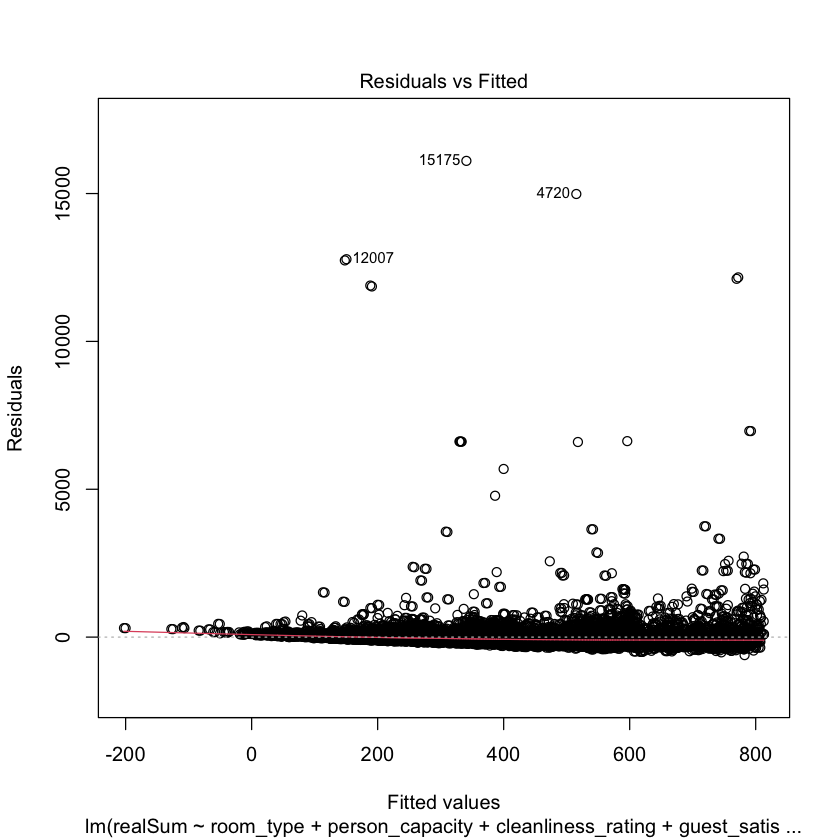

In [ ]:
plot(model_addtive_full, which = 1)

#### Key Observations

1. **Non-random Residual Pattern**:  
   The residuals are not randomly scattered around the horizontal axis. Instead, they appear to fan out and increase as the fitted values increase.

2. **Heteroscedasticity**:  
   The variance of residuals is clearly not constant. As fitted values increase, the spread of residuals becomes wider, violating the constant variance (homoscedasticity) assumption of linear regression.

3. **Non-centered Residuals**:  
   Most residuals lie above zero, indicating a possible bias in the model where it systematically underpredicts prices for some listings.

4. **Outliers**:  
   Several points have extreme residuals (e.g., above 10,000), which may strongly influence the model and distort inference.

#### Implications

- These issues suggest that the assumptions of the linear regression model are violated.
- Specifically, the presence of heteroscedasticity and outliers can lead to:
  - Biased or inefficient coefficient estimates.
  - Invalid standard errors and hypothesis tests.
- The residuals also suggest a non-linear relationship or misspecification in the model.

#### Next Steps

To address these issues, we may consider:
- Applying a log-transformation to the response variable (`realSum`).

## log-transformation Model

### Model Specification

We fit a **log-linear multiple regression model** to explore the nonlinear and interaction effects of various Airbnb listing features on the log-transformed total price (`log(realSum)`).

#### Model Formula

Let \( Y_i = \log(\text{realSum}_i) \), then the model is:

\[
\begin{aligned}
Y_i =\ & \beta_0 + \beta_1 \cdot \text{room\_type}_i + \beta_2 \cdot \text{bedrooms}_i + \beta_3 \cdot (\text{room\_type}_i \times \text{bedrooms}_i) \\
&+ \beta_4 \cdot \text{person\_capacity}_i + \beta_5 \cdot (\text{room\_type}_i \times \text{person\_capacity}_i) \\
&+ \beta_6 \cdot \text{cleanliness\_rating}_i + \beta_7 \cdot \text{cleanliness\_rating}_i^2 \\
&+ \beta_8 \cdot \text{guest\_satisfaction\_overall}_i + \beta_9 \cdot \text{guest\_satisfaction\_overall}_i^2 \\
&+ \beta_{10} \cdot \text{day\_type}_i + \beta_{11} \cdot (\text{day\_type}_i \times \text{person\_capacity}_i) \\
&+ \beta_{12} \cdot \text{dist}_i + \beta_{13} \cdot \text{dist}_i^2 \\
&+ \beta_{14} \cdot \text{metro\_dist}_i + \beta_{15} \cdot \text{metro\_dist}_i^2 \\
&+ \beta_{16} \cdot \text{attr\_index\_norm}_i + \beta_{17} \cdot \text{rest\_index\_norm}_i + \varepsilon_i
\end{aligned}
\]

Where:

- \( \varepsilon_i \sim N(0, \sigma^2) \) is the error term
- Categorical variables (`room_type`, `day_type`) are coded using dummy variables
- \( \log(\text{realSum}) \) ensures that the predicted price remains strictly positive and helps stabilize variance

#### Features of the Model

- Includes **polynomial terms** (squared) to capture potential nonlinear effects (e.g., diminishing returns)
- Includes **interaction terms** between room type and both `bedrooms` and `person_capacity`, as well as between `day_type` and `person_capacity`, to capture conditional effects
- Uses **log-transformed response variable** to reduce skewness and improve model fit

This model allows for both nonlinear relationships and interaction effects, providing a more flexible structure to capture the complex determinants of Airbnb pricing.


In [ ]:
model_additive_log <- lm(log(realSum) ~ 
                         room_type * bedrooms + 
                         room_type * person_capacity + 
                         cleanliness_rating + I(cleanliness_rating^2) + 
                         guest_satisfaction_overall + I(guest_satisfaction_overall^2) + 
                         day_type * person_capacity + 
                         dist + I(dist^2) + 
                         metro_dist + I(metro_dist^2) + 
                         attr_index_norm + rest_index_norm,
                         data = df_all)


In [ ]:
model_addtive_log_result <- tidy(model_additive_log)|>mutate(across(where(is.numeric), ~ round(.x, 4)))
model_addtive_log_result

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5.8517,0.0681,85.8697,0.0000
room_typePrivate room,-0.4194,0.0200,-20.9627,0.0000
room_typeShared room,-0.4704,0.0708,-6.6416,0.0000
bedrooms,0.2249,0.0064,35.0504,0.0000
person_capacity,0.1175,0.0043,27.3711,0.0000
cleanliness_rating,-0.1544,0.0202,-7.6284,0.0000
I(cleanliness_rating^2),0.0128,0.0012,10.2980,0.0000
guest_satisfaction_overall,-0.0146,0.0020,-7.1544,0.0000
I(guest_satisfaction_overall^2),0.0001,0.0000,7.3089,0.0000


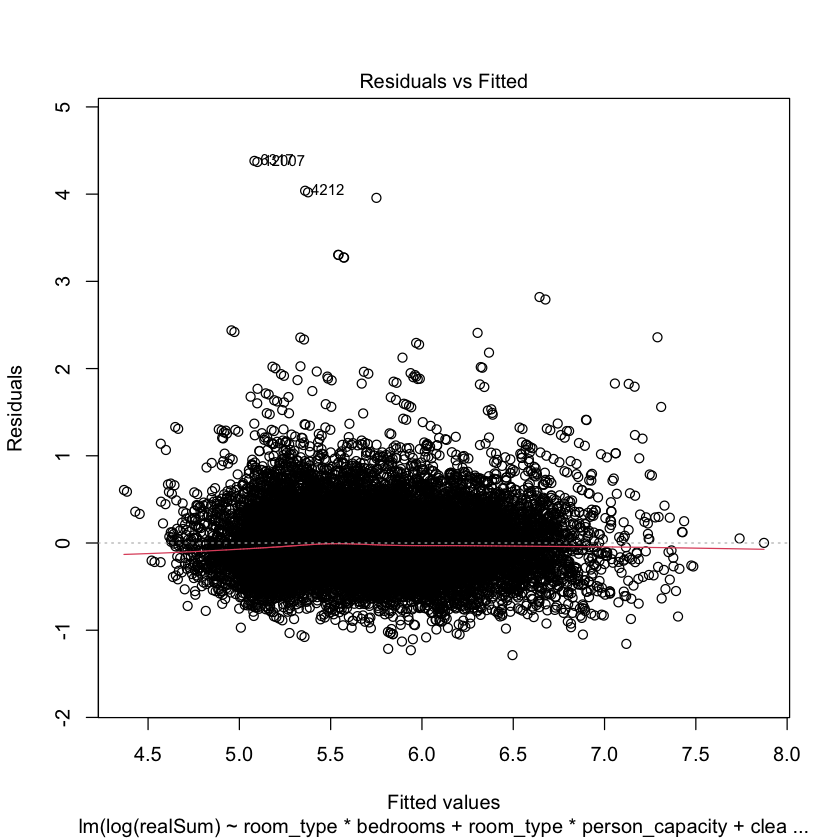

In [ ]:
plot(model_additive_log, which = 1)

### Multicollinearity Diagnosis: Variance Inflation Factor (VIF)

In [ ]:
vif(model_additive_log, type = "predictor")

GVIFs computed for predictors



,GVIF,Df,GVIF^(1/(2*Df)),Interacts With,Other Predictors
,<dbl>,<dbl>,<dbl>,<chr>,<chr>
room_type,2.504469e+00,8,1.059058,"bedrooms, person_capacity","cleanliness_rating, guest_satisfaction_overall, day_type, dist, metro_dist, attr_index_norm, rest_index_norm"
bedrooms,1.147277e+02,5,1.606819,room_type,"person_capacity, cleanliness_rating, guest_satisfaction_overall, day_type, dist, metro_dist, attr_index_norm, rest_index_norm"
person_capacity,3.555379e+16,7,15.212694,"room_type, day_type","bedrooms, cleanliness_rating, guest_satisfaction_overall, dist, metro_dist, attr_index_norm, rest_index_norm"
cleanliness_rating,3.829855e+00,2,1.398929,I(cleanliness_rating^2),"room_type, bedrooms, person_capacity, guest_satisfaction_overall, day_type, dist, metro_dist, attr_index_norm, rest_index_norm"
guest_satisfaction_overall,3.931779e+00,2,1.408145,I(guest_satisfaction_overall^2),"room_type, bedrooms, person_capacity, cleanliness_rating, day_type, dist, metro_dist, attr_index_norm, rest_index_norm"
day_type,2.921352e+00,3,1.195631,person_capacity,"room_type, bedrooms, cleanliness_rating, guest_satisfaction_overall, dist, metro_dist, attr_index_norm, rest_index_norm"
dist,5.278030e+00,2,1.515716,I(dist^2),"room_type, bedrooms, person_capacity, cleanliness_rating, guest_satisfaction_overall, day_type, metro_dist, attr_index_norm, rest_index_norm"
metro_dist,3.103541e+00,2,1.327286,I(metro_dist^2),"room_type, bedrooms, person_capacity, cleanliness_rating, guest_satisfaction_overall, day_type, dist, attr_index_norm, rest_index_norm"
attr_index_norm,1.524192e+00,1,1.234582,--,"room_type, bedrooms, person_capacity, cleanliness_rating, guest_satisfaction_overall, day_type, dist, metro_dist, rest_index_norm"


#### Key Findings:

- `person_capacity` shows **extreme multicollinearity**, with a GVIF^(1/(2*Df)) of **16.79**, far exceeding the common threshold of 5 or 10. This is likely due to its inclusion in two interaction terms: `room_type * person_capacity` and `day_type * person_capacity`.
  
- We will delet person_capacity

### Model Refinement: Dropping Redundant and Insignificant Terms

To improve model stability and interpretability, we refined our log-linear regression model by removing variables with:

- **High multicollinearity** (as diagnosed via GVIF)
- **Statistical insignificance** (p > 0.05)
- **Undefined coefficients** (NA values)

#### Dropped Variables:

- `person_capacity` and all its interactions
    - Extremely high GVIF: 16.79
    - Variance inflation due to interaction with `day_type` and `room_type`
- `day_typeweekend` and its interaction with `person_capacity`
    - p-values > 0.3, suggesting no statistically significant effect
- `room_typeShared room:bedrooms`
    - Coefficient undefined (NA)



In [ ]:
model_additive_log_refine <- lm(log(realSum) ~ 
                         room_type + bedrooms + 
                         + cleanliness_rating 
                                + I(cleanliness_rating^2) + 
                         guest_satisfaction_overall + I(guest_satisfaction_overall^2) + 
                          + dist + I(dist^2) + 
                         metro_dist + I(metro_dist^2) + 
                         attr_index_norm + rest_index_norm,
                         data = df_all)

In [ ]:
model_additive_log_refine_result <- tidy(model_additive_log_refine,conf.int =TRUE)|>mutate(across(where(is.numeric), ~ round(.x, 4)))
model_additive_log_refine_result
summary(model_additive_log_refine)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.0991,0.0706,86.3435,0.0000,5.9606,6.2375
room_typePrivate room,-0.6097,0.0060,-100.9253,0.0000,-0.6215,-0.5978
room_typeShared room,-0.9152,0.0314,-29.1305,0.0000,-0.9768,-0.8536
bedrooms,0.3355,0.0048,70.4949,0.0000,0.3262,0.3448
cleanliness_rating,-0.1558,0.0212,-7.3330,0.0000,-0.1974,-0.1142
I(cleanliness_rating^2),0.0127,0.0013,9.6963,0.0000,0.0101,0.0152
guest_satisfaction_overall,-0.0115,0.0021,-5.3778,0.0000,-0.0157,-0.0073
I(guest_satisfaction_overall^2),0.0001,0.0000,5.1662,0.0000,0.0000,0.0001
dist,0.0113,0.0040,2.7969,0.0052,0.0034,0.0192



Call:
lm(formula = log(realSum) ~ room_type + bedrooms + +cleanliness_rating + 
    I(cleanliness_rating^2) + guest_satisfaction_overall + I(guest_satisfaction_overall^2) + 
    +dist + I(dist^2) + metro_dist + I(metro_dist^2) + attr_index_norm + 
    rest_index_norm, data = df_all)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5802 -0.2582 -0.0327  0.2135  4.3218 

Coefficients:
                                  Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                      6.099e+00  7.064e-02   86.344  < 2e-16 ***
room_typePrivate room           -6.097e-01  6.041e-03 -100.925  < 2e-16 ***
room_typeShared room            -9.152e-01  3.142e-02  -29.131  < 2e-16 ***
bedrooms                         3.355e-01  4.759e-03   70.495  < 2e-16 ***
cleanliness_rating              -1.558e-01  2.125e-02   -7.333 2.34e-13 ***
I(cleanliness_rating^2)          1.265e-02  1.305e-03    9.696  < 2e-16 ***
guest_satisfaction_overall      -1.150e-02  2.139e-03   -5.378 7.62e-08 **

### ANOVA: Model Refinement Evaluation

In [ ]:
model_additive_log_refine_no2 <- lm(log(realSum) ~ 
                         room_type + bedrooms + 
                         + cleanliness_rating 
                         + guest_satisfaction_overall 
                          + dist+
                         metro_dist +  
                         attr_index_norm + rest_index_norm,
                         data = df_all)

In [ ]:
anova(model_additive_log_refine_no2,model_additive_log_refine)|>mutate(across(where(is.numeric), ~ round(.x, 4)))
summary(model_additive_log_refine_no2)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,19504,2997.262,NA,NA,NA,NA
2,19500,2946.087,4,51.175,84.6812,0



Call:
lm(formula = log(realSum) ~ room_type + bedrooms + +cleanliness_rating + 
    guest_satisfaction_overall + dist + metro_dist + attr_index_norm + 
    rest_index_norm, data = df_all)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6191 -0.2625 -0.0358  0.2119  4.2806 

Coefficients:
                             Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                 4.9944030  0.0300908  165.978  < 2e-16 ***
room_typePrivate room      -0.6110758  0.0060464 -101.065  < 2e-16 ***
room_typeShared room       -0.9172931  0.0316771  -28.958  < 2e-16 ***
bedrooms                    0.3370722  0.0047859   70.430  < 2e-16 ***
cleanliness_rating          0.0489928  0.0037623   13.022  < 2e-16 ***
guest_satisfaction_overall -0.0016033  0.0003982   -4.026 5.68e-05 ***
dist                        0.0033011  0.0019278    1.712   0.0869 .  
metro_dist                 -0.0617905  0.0039481  -15.651  < 2e-16 ***
attr_index_norm             0.0150996  0.0003243   46.561  < 2e


We compared two nested models using ANOVA:

- **Reduced Model**: Removed all quadratic terms (no squared predictors)
- **Full Model**: Included quadratic terms for `cleanliness_rating`, `guest_satisfaction_overall`, `dist`, and `metro_dist`

#### Results:

| Statistic | Value     |
|-----------|-----------|
| Degrees of Freedom Difference | 4       |
| F-statistic                   | 84.68   |
| p-value                       | < 0.0001|

#### Interpretation:

The very low p-value indicates that the full model with quadratic terms provides a **significantly better fit** than the reduced model. Thus, we retain the squared terms to capture non-linear effects of cleanliness, guest satisfaction, and distance on log(price).

Including these higher-order terms enhances model accuracy and reflects the real-world intuition that effects may not be strictly linear.
